### License

Copyright 2021 Patrick Hall (jphall@gwu.edu), Melis Diken(midiken@gwu.edu)

Licensed under the Apache License, Version 2.0 (the "License"); you may not use this file except in compliance with the License. You may obtain a copy of the License at

http://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing, software distributed under the License is distributed on an "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied. See the License for the specific language governing permissions and limitations under the License.

DISCLAIMER: This notebook is not legal or compliance advice.

## Assignment 5

In [1]:
import numpy as np                                                # for basic array manipulation                            
import pandas as pd                                               # for dataframe manipulation
import time                                                       # for timers
import xgboost as xgb                                             # base xgboost package for python


# plotting functionality
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D # necessary for custom legends

# display plots in notebook
%matplotlib inline

# set numpy random seed for better reproducibility
SEED = 12345 
np.random.seed(SEED)

# set number of threads
NTHREAD = 4



#### Start global timer

In [2]:
tic = time.time()

#### Import data

In [3]:
data = pd.read_csv('hmda_train_preprocessed.csv')

#### Assign basic modeling roles

In [4]:
y_name = 'high_priced'

### Fit interpretable models

#### Split data into train and validation partitions

In [5]:
np.random.seed(SEED) # preserve exact reproducibility for this cell

split_ratio = 0.7 # 70%/30% train/test split

# execute split
split = np.random.rand(len(data)) < split_ratio
train = data[split]
valid = data[~split]

# summarize split
print('Train data rows = %d, columns = %d' % (train.shape[0], train.shape[1]))
print('Validation data rows = %d, columns = %d' % (valid.shape[0], valid.shape[1]))

# benchmark - Train data rows = 112253, columns = 23
# benchmark - Validation data rows = 48085, columns = 23

Train data rows = 112253, columns = 23
Validation data rows = 48085, columns = 23


### Monotonic XGBoost

#### Retrain most accurate model above 0.8 AIR to act as blackbox prediction API¶

In [6]:
# params dict for remediated models
rem_params = {'colsample_bytree': 0.3,
             'colsample_bylevel': 0.9,
             'eta': 0.005,
             'max_depth': 7,
             'reg_alpha': 0.05,
             'reg_lambda': 0.0005,
             'subsample': 0.7,
             'min_child_weight': 10,
             'gamma': 0.4,
             'booster': 'gbtree',
             'eval_metric': 'auc',
             'monotone_constraints': (1,),
             'nthread': 4,
             'objective': 'binary:logistic',
             'seed': 12345}

rem_x_names = ['no_intro_rate_period_std',
             'debt_to_income_ratio_missing',
             'loan_to_value_ratio_std',
             'intro_rate_period_std',
             'conforming',
             'debt_to_income_ratio_std',
             'income_std',
             'loan_amount_std',
             'term_360']

# retrain

dtrain = xgb.DMatrix(train[rem_x_names], train[y_name])
dvalid = xgb.DMatrix(valid[rem_x_names], valid[y_name])
watchlist = [(dtrain, 'train'), (dvalid, 'eval')]
ntree=1000
early_stopping_rounds=100
rem_mxgb= xgb.train(rem_params,
                    dtrain,
                    ntree,
                    early_stopping_rounds=early_stopping_rounds,
                    evals=watchlist)   
        

    

print('Remediated XGB retrained with AUC: %.4f.' % rem_mxgb.best_score)


[0]	train-auc:0.63716	eval-auc:0.64160
[1]	train-auc:0.63733	eval-auc:0.64191
[2]	train-auc:0.76864	eval-auc:0.76897
[3]	train-auc:0.76996	eval-auc:0.77085
[4]	train-auc:0.78070	eval-auc:0.77963
[5]	train-auc:0.77899	eval-auc:0.77737
[6]	train-auc:0.77310	eval-auc:0.77250
[7]	train-auc:0.77219	eval-auc:0.77174
[8]	train-auc:0.76455	eval-auc:0.76304
[9]	train-auc:0.76518	eval-auc:0.76387
[10]	train-auc:0.76545	eval-auc:0.76363
[11]	train-auc:0.78312	eval-auc:0.78103
[12]	train-auc:0.79068	eval-auc:0.78958
[13]	train-auc:0.79128	eval-auc:0.79060
[14]	train-auc:0.79123	eval-auc:0.79049
[15]	train-auc:0.79138	eval-auc:0.79084
[16]	train-auc:0.79130	eval-auc:0.79069
[17]	train-auc:0.79182	eval-auc:0.79084
[18]	train-auc:0.79154	eval-auc:0.79064
[19]	train-auc:0.79220	eval-auc:0.79133
[20]	train-auc:0.79600	eval-auc:0.79519
[21]	train-auc:0.79584	eval-auc:0.79497
[22]	train-auc:0.79577	eval-auc:0.79458
[23]	train-auc:0.79472	eval-auc:0.79339
[24]	train-auc:0.79161	eval-auc:0.78980
[25]	train

[203]	train-auc:0.80212	eval-auc:0.80113
[204]	train-auc:0.80226	eval-auc:0.80125
[205]	train-auc:0.80223	eval-auc:0.80117
[206]	train-auc:0.80247	eval-auc:0.80153
[207]	train-auc:0.80243	eval-auc:0.80145
[208]	train-auc:0.80237	eval-auc:0.80132
[209]	train-auc:0.80215	eval-auc:0.80110
[210]	train-auc:0.80202	eval-auc:0.80086
[211]	train-auc:0.80212	eval-auc:0.80094
[212]	train-auc:0.80164	eval-auc:0.80045
[213]	train-auc:0.80122	eval-auc:0.79988
[214]	train-auc:0.80099	eval-auc:0.79963
[215]	train-auc:0.80053	eval-auc:0.79918
[216]	train-auc:0.80049	eval-auc:0.79911
[217]	train-auc:0.79999	eval-auc:0.79859
[218]	train-auc:0.79959	eval-auc:0.79806
[219]	train-auc:0.79937	eval-auc:0.79776
[220]	train-auc:0.79929	eval-auc:0.79761
[221]	train-auc:0.79901	eval-auc:0.79740
[222]	train-auc:0.79900	eval-auc:0.79740
[223]	train-auc:0.79873	eval-auc:0.79715
[224]	train-auc:0.79922	eval-auc:0.79773
[225]	train-auc:0.79922	eval-auc:0.79773
[226]	train-auc:0.79941	eval-auc:0.79803
[227]	train-auc:

## Sensitivity Analysis: Stress Testing

#### Simulate recession conditions in validation data

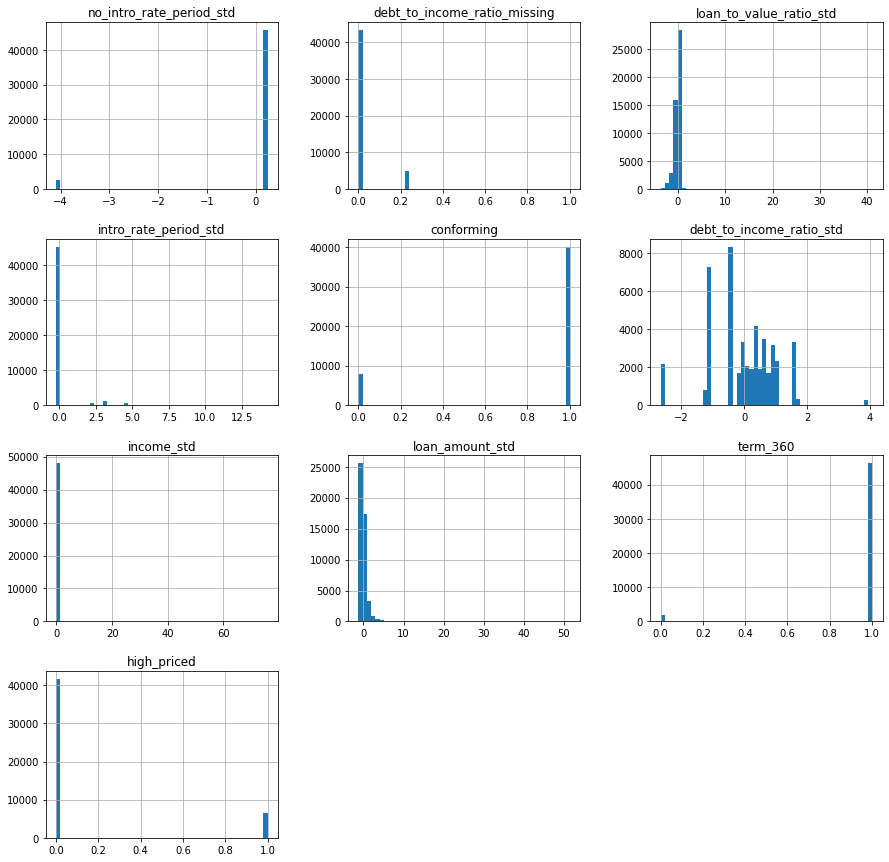

In [7]:

rec_valid = valid.copy(deep=True) # deep copy of validation data

# use severity variable to control how many customers are affected
severity = 0.1
affected = np.random.rand(len(rec_valid)) < severity


# less intro rates
rec_valid.loc[affected, 'no_intro_rate_period_std'] = 0.2443944

# 5% higher debt-to-income ratios 
rec_valid.loc[affected, 'debt_to_income_ratio_missing'] = 0.234552

# lower loan amounts by 5%
rec_valid.loc[affected, 'loan_amount_std'] = rec_valid.loc[affected, 'loan_amount_std'] * 0.95

# lower income by 5%
rec_valid.loc[affected, 'income_std'] = rec_valid.loc[affected, 'income_std'] * 0.95

# less conforming loans
rec_valid.loc[affected, 'conforming'] = 0

# shorter intro rate periods
rec_valid.loc[affected, 'intro_rate_period_std'] = rec_valid.loc[affected, 'intro_rate_period_std'] * 0.95

# 5% higher loan_to_value ratios 
rec_valid.loc[affected, 'loan_to_value_ratio_std'] = rec_valid.loc[affected, 'loan_to_value_ratio_std'] * 1.05


# 5% higher debt-to-income ratios 
rec_valid.loc[affected, 'debt_to_income_ratio_std'] = rec_valid.loc[affected, 'debt_to_income_ratio_std'] * 1.05

# more long loans
rec_valid.loc[affected, 'term_360'] = 1

# update target
rec_valid.loc[affected, y_name] = np.random.choice(2, len(rec_valid.loc[affected, y_name]))

# visualize results
_ = rec_valid[rem_x_names + [y_name]].hist(bins=50, figsize=(15, 15))

#### Find AUC for best model in simulated recession conditions

In [8]:
dvalid = xgb.DMatrix(rec_valid[rem_x_names], rec_valid[y_name])
watchlist = [(dtrain, 'train'), (dvalid, 'eval')]
ntree=1000
early_stopping_rounds=100
rec_rem_mxgb_perf= xgb.train(rem_params,
                    dtrain,
                    ntree,
                    early_stopping_rounds=early_stopping_rounds,
                    evals=watchlist)   
        

    

print('Remediated XGB retrained with AUC: %.4f.' % rec_rem_mxgb_perf.best_score)


[0]	train-auc:0.63716	eval-auc:0.59728
[1]	train-auc:0.63733	eval-auc:0.59738
[2]	train-auc:0.76864	eval-auc:0.67227
[3]	train-auc:0.76996	eval-auc:0.67750
[4]	train-auc:0.78070	eval-auc:0.68174
[5]	train-auc:0.77899	eval-auc:0.68135
[6]	train-auc:0.77310	eval-auc:0.67793
[7]	train-auc:0.77219	eval-auc:0.67792
[8]	train-auc:0.76455	eval-auc:0.67194
[9]	train-auc:0.76518	eval-auc:0.67349
[10]	train-auc:0.76545	eval-auc:0.67356
[11]	train-auc:0.78312	eval-auc:0.67810
[12]	train-auc:0.79068	eval-auc:0.67937
[13]	train-auc:0.79128	eval-auc:0.68185
[14]	train-auc:0.79123	eval-auc:0.66439
[15]	train-auc:0.79138	eval-auc:0.66535
[16]	train-auc:0.79130	eval-auc:0.64900
[17]	train-auc:0.79182	eval-auc:0.65185
[18]	train-auc:0.79154	eval-auc:0.63879
[19]	train-auc:0.79220	eval-auc:0.64167
[20]	train-auc:0.79600	eval-auc:0.64666
[21]	train-auc:0.79584	eval-auc:0.63450
[22]	train-auc:0.79577	eval-auc:0.63675
[23]	train-auc:0.79472	eval-auc:0.63784
[24]	train-auc:0.79161	eval-auc:0.63825
[25]	train

## Residual Analysis

#### Calculate predictions and logloss residuals for all data

In [9]:
# shortcut names
yhat_name = 'phat'
r_name = 'r' 

# create a frame with remediated XGB predictions
dvalid = xgb.DMatrix(valid[rem_x_names], valid[y_name])
rem_mxgb_phat= pd.DataFrame(rec_rem_mxgb_perf.predict(dvalid, iteration_range=(0, rec_rem_mxgb_perf.best_ntree_limit)), columns=['phat']) 
rem_mxgb_phat = pd.concat([valid.reset_index(drop=True), rem_mxgb_phat], axis=1)

# calculate logloss residuals
rem_mxgb_phat[r_name] = -rem_mxgb_phat[y_name]*np.log(rem_mxgb_phat[yhat_name]) -\
                       (1 - rem_mxgb_phat[y_name])*np.log(1 - rem_mxgb_phat[yhat_name]) 

Model preform very poorly on the recession conditions and basically uses the mean to predict 

#### Plot residuals

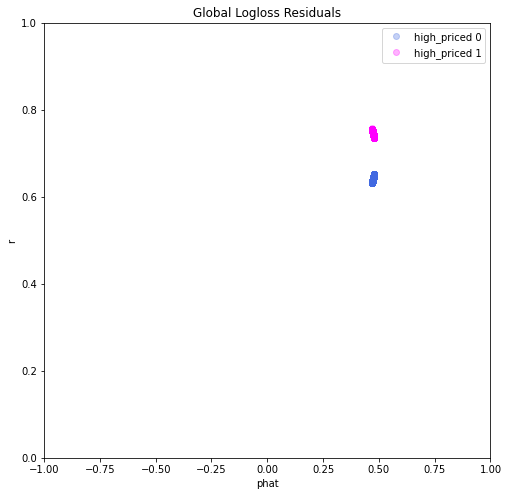

In [10]:
# initialize figure
fig, ax_ = plt.subplots(figsize=(8, 8))         

# plot groups with appropriate color
color_list = ['royalblue', 'magenta'] 
c_idx = 0
groups = rem_mxgb_phat.groupby(y_name) # define groups for levels of PAY_0
for name, group in groups:
    ax_.plot(group.phat, group.r, 
             label=' '.join([y_name, str(name)]),
             marker='o', linestyle='', color=color_list[c_idx], alpha=0.3)
    c_idx += 1
    
# annotate plot
_ = ax_.set_ylim(0, 1)
_ = ax_.set_xlim(-1, 1)
_ = plt.xlabel(yhat_name)
_ = plt.ylabel(r_name)
_ = ax_.legend(loc=1)
_ = plt.title('Global Logloss Residuals')

## Remediation: Remove Outliers

#### Find outliers

In [11]:
rem_mxgb_phat.sort_values(by='r', ascending=False).head()

,row_id,black,asian,white,amind,hipac,hispanic,non_hispanic,male,female,...,loan_amount_std,loan_to_value_ratio_std,no_intro_rate_period_std,intro_rate_period_std,property_value_std,income_std,debt_to_income_ratio_std,high_priced,phat,r
33159,110822,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,...,0.892723,-0.874794,0.244394,-0.215304,1.252485,-0.007738,-1.156406,1,0.468588,0.758032
28525,95084,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,...,1.904087,-0.453255,-4.091747,2.197776,1.869180,0.178668,-1.156406,1,0.469207,0.756711
30667,102478,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,...,5.333933,-0.654098,-4.091747,2.197776,5.507684,0.269100,-2.527547,1,0.469225,0.756674
9658,32019,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,...,1.904087,-0.631106,-4.091747,2.237994,2.054189,0.137784,-0.425131,1,0.469264,0.756590
32426,108518,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,...,3.926817,-0.647496,-4.091747,2.278212,4.089284,0.270832,-1.156406,1,0.469275,0.756567


#### Remove worst outliers

In [12]:
n_remove = 10
rem_data = data.copy(deep=True)
rem_data.drop(list(rem_mxgb_phat.sort_values(by='r', ascending=False).head(n=n_remove).index), axis=0, inplace=True)

### Remediation: Down-sample to Increase Signal from High-priced Loans

In [13]:
inverse_proportion_remove = 2 # corresponds to keeping 1 - (1/inverse_proportion_remove) rows
rem_data.drop(list(rem_data[rem_data[y_name] == 0].index)[::inverse_proportion_remove], axis=0, inplace=True)

#### Retrain remediated Mxgb

In [14]:
np.random.seed(SEED) # preserve exact reproducibility for this cell

# execute split
split = np.random.rand(len(rem_data)) < split_ratio
rem_train = rem_data[split]
rem_valid = rem_data[~split]

# summarize split
print('Remediated train data rows = %d, columns = %d' % (rem_train.shape[0], rem_train.shape[1]))
print('Remediated validation data rows = %d, columns = %d' % (rem_valid.shape[0], rem_valid.shape[1]))

# retrain
dtrain = xgb.DMatrix(rem_train[rem_x_names], rem_train[y_name])
dvalid = xgb.DMatrix(rem_valid[rem_x_names], rem_valid[y_name])
watchlist = [(dtrain, 'train'), (dvalid, 'eval')]
ntree=1000
early_stopping_rounds=100
rem_mxgb2= xgb.train(rem_params,
                    dtrain,
                    ntree,
                    early_stopping_rounds=early_stopping_rounds,
                    evals=watchlist)   
        

    

print('Remediated XGB retrained with AUC: %.4f.' % rem_mxgb2.best_score)

Remediated train data rows = 61520, columns = 23
Remediated validation data rows = 26395, columns = 23
[0]	train-auc:0.63226	eval-auc:0.63218
[1]	train-auc:0.67498	eval-auc:0.67172
[2]	train-auc:0.69977	eval-auc:0.69955
[3]	train-auc:0.76126	eval-auc:0.75993
[4]	train-auc:0.75268	eval-auc:0.75091
[5]	train-auc:0.74486	eval-auc:0.74230
[6]	train-auc:0.74414	eval-auc:0.74165
[7]	train-auc:0.73322	eval-auc:0.73137
[8]	train-auc:0.74924	eval-auc:0.74781
[9]	train-auc:0.75343	eval-auc:0.75203
[10]	train-auc:0.75744	eval-auc:0.75597
[11]	train-auc:0.75693	eval-auc:0.75553
[12]	train-auc:0.76006	eval-auc:0.75803
[13]	train-auc:0.76079	eval-auc:0.75906
[14]	train-auc:0.77850	eval-auc:0.77739
[15]	train-auc:0.77809	eval-auc:0.77704
[16]	train-auc:0.79595	eval-auc:0.79562
[17]	train-auc:0.79374	eval-auc:0.79297
[18]	train-auc:0.79953	eval-auc:0.79963
[19]	train-auc:0.79617	eval-auc:0.79635
[20]	train-auc:0.79325	eval-auc:0.79280
[21]	train-auc:0.79308	eval-auc:0.79264
[22]	train-auc:0.78866	eval

#### Test remediated XGB on true validation data

In [15]:
dvalid = xgb.DMatrix(valid[rem_x_names], valid[y_name])

rem_mxgb_phat2= pd.DataFrame(rem_mxgb.predict(dvalid, iteration_range=(0, rem_mxgb.best_ntree_limit)), columns=['phat']) 
rem_mxgb_phat2 = pd.concat([valid.reset_index(drop=True), rem_mxgb_phat2], axis=1)


watchlist = [(dtrain, 'train'), (dvalid, 'eval')]
ntree=1000
early_stopping_rounds=100
rem_mxgb3= xgb.train(rem_params,
                    dtrain,
                    ntree,
                    early_stopping_rounds=early_stopping_rounds,
                    evals=watchlist)   
        

    

print('Remediated XGB retrained with AUC: %.4f.' % rem_mxgb3.best_score)

[0]	train-auc:0.63226	eval-auc:0.63789
[1]	train-auc:0.67498	eval-auc:0.67479
[2]	train-auc:0.69977	eval-auc:0.70277
[3]	train-auc:0.76126	eval-auc:0.76389
[4]	train-auc:0.75268	eval-auc:0.75537
[5]	train-auc:0.74486	eval-auc:0.74796
[6]	train-auc:0.74414	eval-auc:0.74708
[7]	train-auc:0.73322	eval-auc:0.73628
[8]	train-auc:0.74924	eval-auc:0.75186
[9]	train-auc:0.75343	eval-auc:0.75593
[10]	train-auc:0.75744	eval-auc:0.75929
[11]	train-auc:0.75693	eval-auc:0.75882
[12]	train-auc:0.76006	eval-auc:0.76187
[13]	train-auc:0.76079	eval-auc:0.76299
[14]	train-auc:0.77850	eval-auc:0.78046
[15]	train-auc:0.77809	eval-auc:0.78010
[16]	train-auc:0.79595	eval-auc:0.79857
[17]	train-auc:0.79374	eval-auc:0.79629
[18]	train-auc:0.79953	eval-auc:0.80263
[19]	train-auc:0.79617	eval-auc:0.79926
[20]	train-auc:0.79325	eval-auc:0.79596
[21]	train-auc:0.79308	eval-auc:0.79582
[22]	train-auc:0.78866	eval-auc:0.79136
[23]	train-auc:0.78970	eval-auc:0.79232
[24]	train-auc:0.78656	eval-auc:0.78884
[25]	train

##### End timer

In [16]:
toc = time.time() - tic
print('All tasks completed in %.2f s.' % (toc))

All tasks completed in 22.44 s.
